In [156]:
import numpy as np

In [157]:
def log_p(x):
    x1, x2 = x
    beta = 0.03
    sigma_x = 2.0
    sigma_y = 0.5
    term1 = -0.5 * (x1 / sigma_x) ** 2
    term2 = -0.5 * ((x2 + beta * (x1**2 - sigma_x**2)) / sigma_y) ** 2
    return term1 + term2

def p(x):
    return np.exp(log_p(np.asarray(x, dtype=float)))


In [158]:
cov = np.diag([1, 1])

In [159]:
def q_sample(x):
    return np.random.multivariate_normal(x, cov)

In [160]:
def q_log_prob(x, theta):
    x = np.asarray(x, dtype=float)
    theta = np.asarray(theta, dtype=float)
    diff = x - theta

    inv = np.linalg.inv(cov)
    sign, log_det = np.linalg.slogdet(cov)
    dim = diff.size
    log_norm = -0.5 * (dim * np.log(2.0 * np.pi) + log_det)
    exponent = -0.5 * diff @ inv @ diff
    return log_norm + exponent 

In [161]:
def log_accept_ratio(theta_star, theta):
    return (
        log_p(theta_star)
        + q_log_prob(theta, theta_star)  # reverse proposal
        - log_p(theta)
        - q_log_prob(theta_star, theta)  # forward proposal
    )

In [162]:
def MH(n_samples=1000, initial=None):
    theta = np.array([0.0, 0.0]) if initial is None else np.asarray(initial, dtype=float)
    samples = [theta.copy()]
    for _ in range(n_samples):
        theta_star = q_sample(theta)
        if np.log(np.random.rand()) < log_accept_ratio(theta_star, theta):
            theta = theta_star
        samples.append(theta.copy())
    return np.asarray(samples)


In [163]:
# Generate a chain
samples = np.array(MH())
burn_in = 200  # tweak if needed
chain = samples[burn_in:]

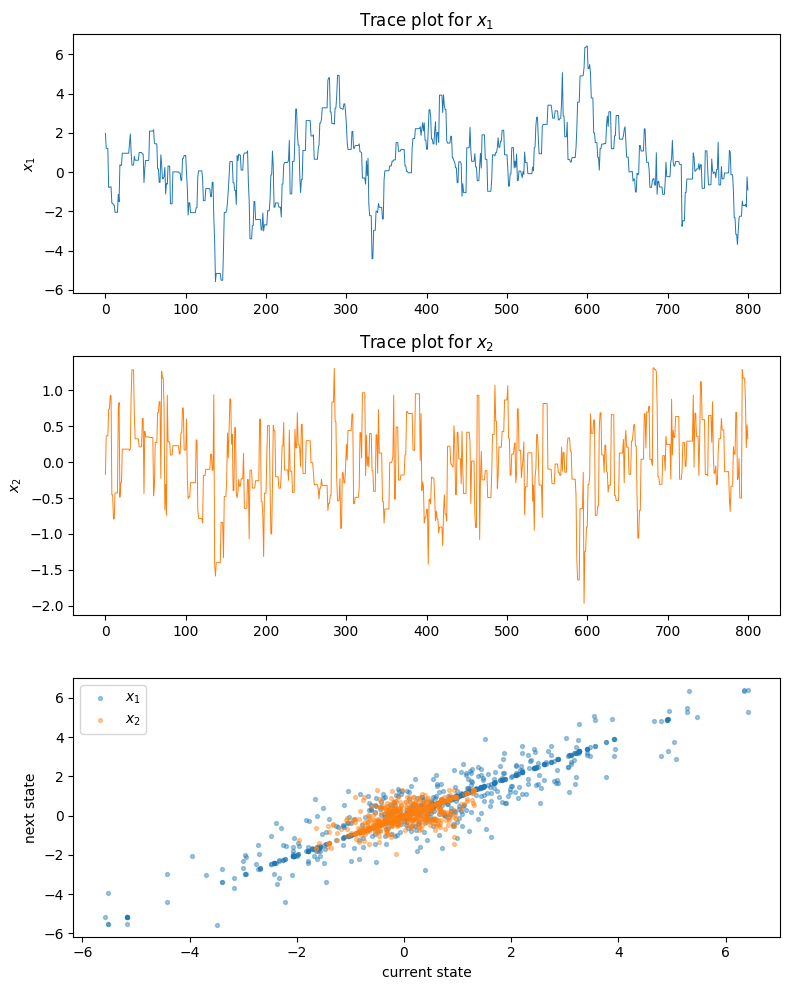

In [164]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=False)

# Trace plots
axs[0].plot(chain[:, 0], color="tab:blue", linewidth=0.7)
axs[0].set_ylabel(r"$x_1$")
axs[0].set_title("Trace plot for $x_1$")

axs[1].plot(chain[:, 1], color="tab:orange", linewidth=0.7)
axs[1].set_ylabel(r"$x_2$")
axs[1].set_title("Trace plot for $x_2$")

# Autocorrelation-style quick look (lag-1 scatter)
axs[2].scatter(chain[:-1, 0], chain[1:, 0], s=8, alpha=0.4, label=r"$x_1$")
axs[2].scatter(chain[:-1, 1], chain[1:, 1], s=8, alpha=0.4, label=r"$x_2$")
axs[2].set_xlabel("current state")
axs[2].set_ylabel("next state")
axs[2].legend()

plt.tight_layout()
plt.show()

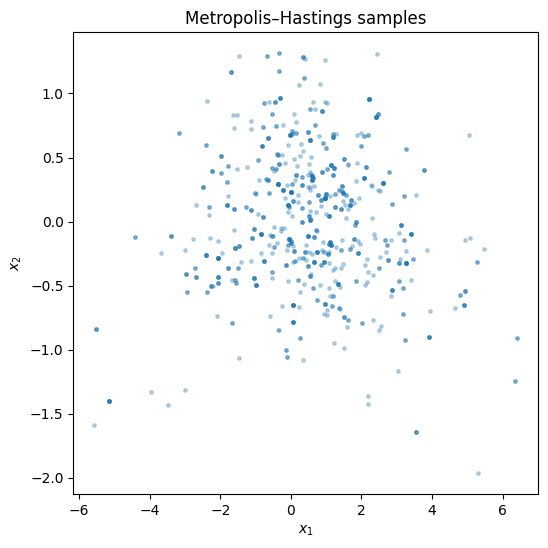

In [165]:
# 2-D view of the banana target
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(chain[:, 0], chain[:, 1], s=6, alpha=0.3)
ax.set_title("Metropolis–Hastings samples")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
plt.show()

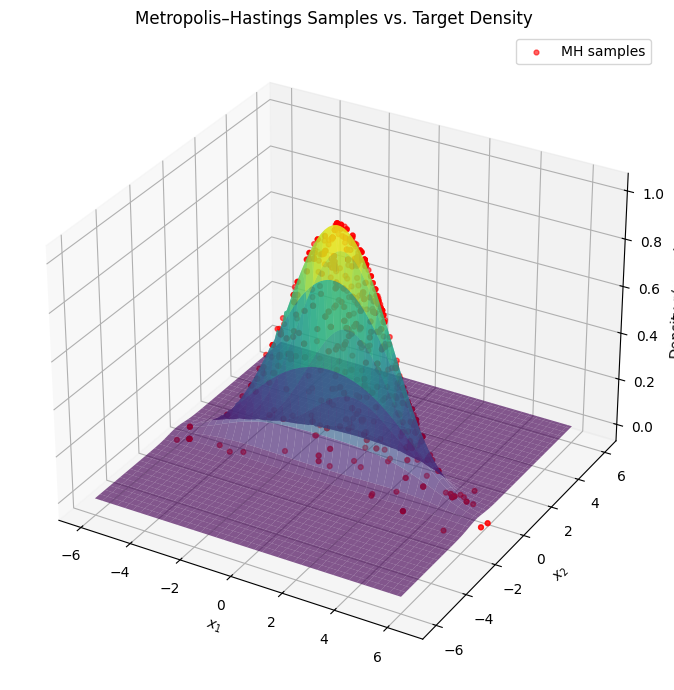

In [166]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt

# assume `chain` already holds the post burn-in samples (shape: [n, 2])

# grid for true density
x1_lim = (-6, 6)
x2_lim = (-6, 6)
x1 = np.linspace(*x1_lim, 80)
x2 = np.linspace(*x2_lim, 80)
X1, X2 = np.meshgrid(x1, x2)


def banana_density_grid(x1_vals, x2_vals):
    beta = 0.03
    sigma_x = 2.0
    sigma_y = 0.5
    term1 = -0.5 * (x1_vals / sigma_x) ** 2
    term2 = -0.5 * ((x2_vals + beta * (x1_vals**2 - sigma_x**2)) / sigma_y) ** 2
    return np.exp(term1 + term2)


Z_true = banana_density_grid(X1, X2)

# sample "heights" using true density for clarity (alternative: KDE)
sample_z = np.apply_along_axis(p, 1, chain)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# true surface
ax.plot_surface(X1, X2, Z_true, cmap="viridis", alpha=0.65, linewidth=0)

# samples as scatter
ax.scatter(
    chain[:, 0], chain[:, 1], sample_z, color="red", s=12, alpha=0.6, label="MH samples"
)

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"Density $p(x_1, x_2)$")
ax.set_title("Metropolis–Hastings Samples vs. Target Density")
ax.legend()

plt.tight_layout()
plt.show()